In [1]:
%load_ext autoreload
%autoreload 2
from tf_activation import DeepGraph
from tf_activation.models import mnist_cff as mnist_model

import math
import random
import os
from os import listdir
from os.path import isfile, join

import networkx as nx
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.metrics import r2_score
%matplotlib inline
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data

In [2]:
CLUSTER_PATH = '../logdir/data/experiments/cluster_mnist'
SAVE_PATH = '../logdir/models'
ADV_PATH = '../logdir/adversaries/carlini_attacks_targeted5020'
ELITE_PATH = '../logdir/elites'
DATA_PATH = '../logdir/data'
SAVE_FIG_LOC = '../logdir/figures'

centers = np.load(os.path.join(SAVE_PATH, 'average_mnist.npy'))
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
advs = [f for f in listdir(ADV_PATH) if isfile(join(ADV_PATH, f))]
distance_stats = pd.read_pickle(os.path.join(SAVE_PATH, 'distance_stats.pkl'))

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allocator_type = 'BFC'
config.log_device_placement = False

persistence_module = tf.load_op_library('/home/tgebhart/python/tensorflow/bazel-bin/tensorflow/core/user_ops/nn_graph_persistence.so')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def regress(X, y, xlab, ylab, color_vals='#4286f4'):
    
    print(X.shape,y.shape)
    
    # Split the data into training/testing sets
    X_train = X[:-20]
    X_test = X[-20:]

    # Split the targets into training/testing sets
    y_train = y[:-20]
    y_test = y[-20:]

    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, y_train)

    # The coefficients
    print('Coefficients: ', regr.coef_)
    # The mean squared error
    print("Mean squared error: %.2f"
          % np.mean((regr.predict(X_test) - y_test) ** 2))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % regr.score(X_test, y_test))
    print('R^2: %.2f' % r2_score(y_test, regr.predict(X_test)))
    
    fig, ax = plt.subplots()
    X_min = np.min(X)
    X_max = np.max(X)
    y_min = np.min(y)
    y_max = np.max(y)
    # Plot outputs
    
    ax.scatter(X, y,  color=color_vals, s=7)
#     ax.plot(X, regr.predict(X), color='blue', linewidth=3)


    ax.set_xlim(X_min, X_max)
    ax.set_ylim(y_min, y_max)
    
    plt.xlabel(xlab)
    plt.ylabel(ylab)
#     plt.title('{} vs {}'.format(xlab, ylab))
    plt.show()
    fig.savefig(os.path.join(SAVE_FIG_LOC, xlab + '_' + ylab + '.svg'), 
                format='svg', dpi=1200, bbox_inches='tight')

In [4]:
df = pd.read_pickle(os.path.join(DATA_PATH, 'experiments', 'adv_detection.pkl'))

In [5]:
df.head()

,accuracy,cross_entropy,distance_to_average,distance_to_true,is_adv,persistence_distance,predicted_class,y_conv
0,1.0,0.000000,5.839859,5.815623,True,429866.93750,9,"[[-0.393338, -0.294707, -0.322968, -0.0573259,..."
1,1.0,0.000061,6.826564,0.000000,False,545373.18750,9,"[[-0.506011, -0.254453, -0.306653, -0.114728, ..."
2,0.0,19.725807,6.503851,8.637321,True,496731.84375,1,"[[-0.427641, 0.672355, 0.0361633, 0.036158, -0..."
3,1.0,0.000000,7.898295,0.000000,False,671494.25000,4,"[[-0.354384, -0.00370335, -0.160137, -0.31598,..."
4,0.0,16.061516,6.175118,10.191108,True,429508.71875,9,"[[-0.463341, -0.0766205, -0.178128, -0.0371705..."


In [6]:
adv_df = df[df['is_adv'] == True]

((450, 1), (450, 1))
('Coefficients: ', array([[ 55924.00209411]]))
Mean squared error: 2676741677.54
Variance score: 0.81
R^2: 0.81


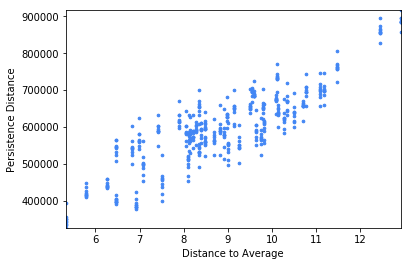

In [23]:
X = df[~df['is_adv']]['distance_to_average'].as_matrix()
y = df[~df['is_adv']]['persistence_distance'].as_matrix()
regress(X.reshape((X.shape[0],1)), y.reshape((y.shape[0],1)), 'Distance to Average', 'Persistence Distance')

((90, 1), (90, 1))
('Coefficients: ', array([[ 45883.80224485]]))
Mean squared error: 2737166537.22
Variance score: 0.84
R^2: 0.84


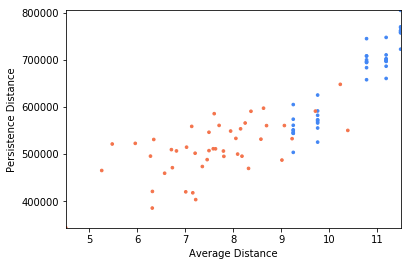

((86, 1), (86, 1))
('Coefficients: ', array([[ 47195.81541093]]))
Mean squared error: 2016205108.89
Variance score: 0.72
R^2: 0.72


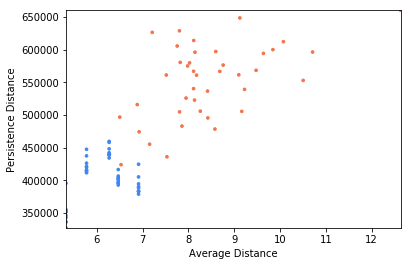

((63, 1), (63, 1))
('Coefficients: ', array([[ 55734.14290348]]))
Mean squared error: 2833568777.18
Variance score: 0.76
R^2: 0.76


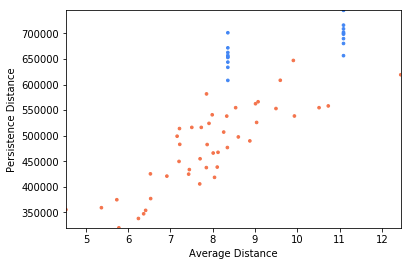

((91, 1), (91, 1))
('Coefficients: ', array([[ 64050.47611338]]))
Mean squared error: 2338721781.75
Variance score: 0.62
R^2: 0.62


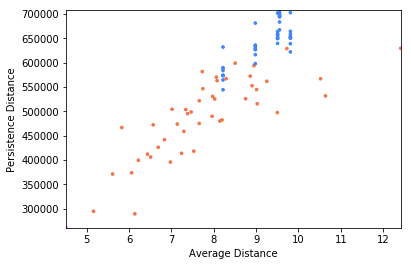

((95, 1), (95, 1))
('Coefficients: ', array([[ 33723.39000123]]))
Mean squared error: 2790031829.94
Variance score: 0.33
R^2: 0.33


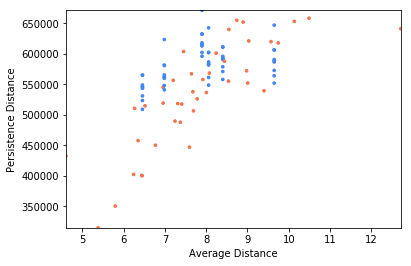

((64, 1), (64, 1))
('Coefficients: ', array([[ 38654.96452734]]))
Mean squared error: 2972824172.79
Variance score: 0.65
R^2: 0.65


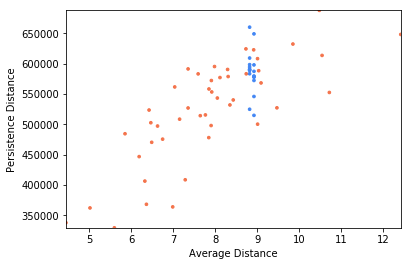

((110, 1), (110, 1))
('Coefficients: ', array([[ 56194.05172449]]))
Mean squared error: 2001831877.14
Variance score: 0.79
R^2: 0.79


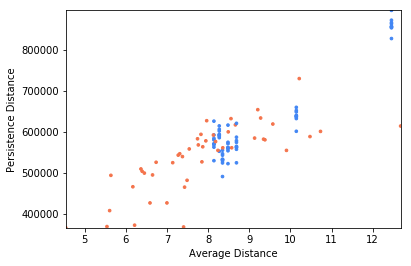

((98, 1), (98, 1))
('Coefficients: ', array([[ 48874.8521659]]))
Mean squared error: 8408378544.72
Variance score: 0.36
R^2: 0.36


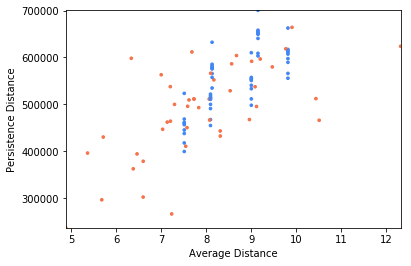

((113, 1), (113, 1))
('Coefficients: ', array([[ 62273.95385847]]))
Mean squared error: 2972417422.79
Variance score: 0.81
R^2: 0.81


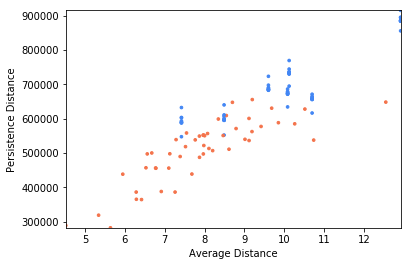

((90, 1), (90, 1))
('Coefficients: ', array([[ 42713.56777776]]))
Mean squared error: 1669878167.14
Variance score: 0.77
R^2: 0.77


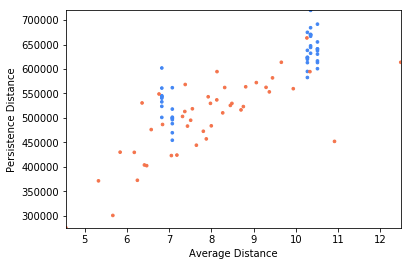

In [8]:
for cls in range(10):
    color_vals = ['#f4734b' if adv else '#4286f4' for adv in df[df['predicted_class'] == cls]['is_adv']]
    X = df[df['predicted_class'] == cls]['distance_to_average'].as_matrix()
    y = df[df['predicted_class'] == cls]['persistence_distance'].as_matrix()
    regress(X.reshape((X.shape[0],1)), y.reshape((y.shape[0],1)), 'Average Distance', 'Persistence Distance', color_vals=color_vals)


In [9]:
distances = []
for cls in range(10):
    col = {}
    col['avg_per_distance_true'] = np.average(df[(df['predicted_class'] == cls) & (df['is_adv'] == False)]['persistence_distance'])
    col['var_per_distance_true'] = np.var(df[(df['predicted_class'] == cls) & (df['is_adv'] == False)]['persistence_distance'])
    col['std_per_distance_true'] = np.std(df[(df['predicted_class'] == cls)  & (df['is_adv'] == False)]['persistence_distance'])
    col['avg_distance_true'] = np.average(df[(df['predicted_class'] == cls)  & (df['is_adv'] == False)]['distance_to_average'])
    col['avg_per_distance_adv'] = np.average(df[(df['predicted_class'] == cls) & (df['is_adv'] == True)]['persistence_distance'])
    col['var_per_distance_adv'] = np.var(df[(df['predicted_class'] == cls) & (df['is_adv'] == True)]['persistence_distance'])
    col['std_per_distance_adv'] = np.std(df[(df['predicted_class'] == cls)  & (df['is_adv'] == True)]['persistence_distance'])
    col['avg_distance_adv'] = np.average(df[(df['predicted_class'] == cls)  & (df['is_adv'] == True)]['distance_to_average'])
    distances.append(col)
sdf = pd.DataFrame(distances, index=list(range(10)))

In [10]:
sdf.head(10)

,avg_distance_adv,avg_distance_true,avg_per_distance_adv,avg_per_distance_true,std_per_distance_adv,std_per_distance_true,var_per_distance_adv,var_per_distance_true
0,7.576567,10.488848,509943.319444,657517.855556,59131.305763,83847.212656,3.496511e+09,7.030355e+09
1,8.380049,6.152847,548998.831555,402082.387500,58515.109652,34309.438515,3.424018e+09,1.177138e+09
2,7.936731,9.724316,478298.300694,676930.659722,80087.193591,32895.217202,6.413959e+09,1.082095e+09
3,7.772737,9.213734,487435.151495,643505.709722,84901.496742,41808.827851,7.208264e+09,1.747978e+09
4,7.844251,7.908370,534000.814787,583629.994213,84576.442617,32514.075850,7.153175e+09,1.057165e+09
5,7.864196,8.872726,524961.472147,585623.071181,83725.059164,34321.417921,7.009886e+09,1.177960e+09
6,7.891557,9.218382,539610.132979,619085.788194,80407.248886,105091.973401,6.465326e+09,1.104432e+10
7,7.908870,8.618590,488213.043679,553872.031829,97902.407665,70129.770263,9.584881e+09,4.918185e+09
8,7.948937,9.903954,509722.288125,690490.041667,89777.640258,94293.957057,8.060025e+09,8.891350e+09
9,7.913286,9.007226,500350.858333,593564.188194,80129.770550,67610.238262,6.420780e+09,4.571144e+09


(array([ 0.,  0.,  0.,  0.,  0.,  3.,  1.,  2.,  2.,  2.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 400000.,  415000.,  430000.,  445000.,  460000.,  475000.,
         490000.,  505000.,  520000.,  535000.,  550000.,  565000.,
         580000.,  595000.,  610000.,  625000.,  640000.,  655000.,
         670000.,  685000.,  700000.]),
 <a list of 20 Patch objects>)

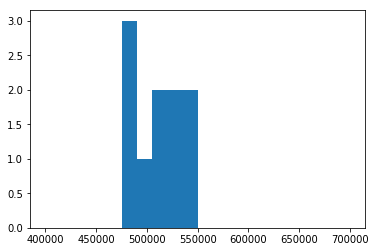

In [21]:
plt.hist(sdf['avg_per_distance_adv'], bins=20, range=[400000,700000])

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  3.,
         0.,  1.,  0.,  1.,  1.,  1.,  1.]),
 array([ 400000.,  415000.,  430000.,  445000.,  460000.,  475000.,
         490000.,  505000.,  520000.,  535000.,  550000.,  565000.,
         580000.,  595000.,  610000.,  625000.,  640000.,  655000.,
         670000.,  685000.,  700000.]),
 <a list of 20 Patch objects>)

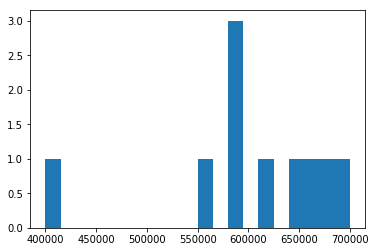

In [22]:
plt.hist(sdf['avg_per_distance_true'], bins=20, range=[400000,700000])

In [ ]:
plt.hist(sdf[sdf['adversary']['avg_per_distance_adv'], bins=20, range=[400000,700000])